Nickhil Tekwani || CS 6220 || Hw 5B

**Problem 1: Simple Sampling**

In [1]:
import math
import random

# A. Continuous Distributions

# Uniform Distribution
def sample_uniform(min_val, max_val, sample_size):
    return [min_val + (max_val - min_val) * random.random() for _ in range(sample_size)]

# Gaussian Distribution using Box-Muller transform
def sample_gaussian(mu, sigma, sample_size):
    out = []
    for _ in range(sample_size // 2 + 1):
        u1, u2 = random.random(), random.random()
        z0 = math.sqrt(-2.0 * math.log(u1)) * math.cos(2 * math.pi * u2)
        z1 = math.sqrt(-2.0 * math.log(u1)) * math.sin(2 * math.pi * u2)
        out.append(sigma * z0 + mu)
        out.append(sigma * z1 + mu)
    return out[:sample_size]

# B. 2-dim Gaussian Distribution

def sample_gaussian_2d(mu, sigma, sample_size):
    out = []
    for _ in range(sample_size):
        z0, z1 = sample_gaussian(0, 1, 2)  # standard normal
        # Construct 2D Gaussian using the independent Gaussian samples
        x = mu[0] + z0 * sigma[0][0] + z1 * sigma[0][1]
        y = mu[1] + z0 * sigma[1][0] + z1 * sigma[1][1]
        out.append((x, y))
    return out

# C. Sampling without replacement from a discrete non-uniform distribution

def sample_without_replacement(probabilities, N):
    # Ensure probabilities sum to 1
    total = sum(probabilities)
    normalized_probs = [p / total for p in probabilities]

    samples = []
    for _ in range(N):
        u = random.random()
        s = 0
        for idx, prob in enumerate(normalized_probs):
            s += prob
            if s > u:
                samples.append(idx)
                break
    return samples

# Testing
print(sample_uniform(0, 10, 5))
print(sample_gaussian(0, 1, 5))
print(sample_gaussian_2d([0,0], [[1, 0.5], [0.5, 1]], 5))
print(sample_without_replacement([0.1, 0.2, 0.7], 2))


[0.039033026276997784, 0.8836236954465515, 8.97570368331722, 5.702341529629516, 4.2595828924855965]
[-0.4514881715416532, -0.5335352285366808, -0.044306251274330306, -0.3637541412068483, -0.22029623109742685]
[(2.5177007393714073, 2.201347777926564), (-0.5195023437247294, 0.4683854962096833), (0.20658918926760264, 0.35386161354778645), (-0.6941863858348212, -0.7385399081865178), (0.46616586668658694, 0.361774919695509)]
[2, 2]


Notes for Problem 1:

For the 2D Gaussian, the code assumes that the covariance matrix is diagonal for simplicity. Adjustments would be needed for a more general covariance matrix.
For the discrete non-uniform sampling, instead of steven's method, the approach shown is a simple way, but it may not be the most efficient for large probability lists.

**Problem 2: Conditional Sampling**

Given a 2D multivariate Gaussian with parameters:

$$
\mu = \begin{bmatrix}
\mu_1 \\
\mu_2
\end{bmatrix}
$$

$$
\Sigma = \begin{bmatrix}
\sigma_{11} & \sigma_{12} \\
\sigma_{21} & \sigma_{22}
\end{bmatrix}
$$

The conditional distributions are:

$$
p(x_1 | x_2) \sim \mathcal{N}\left(\mu_1 + \frac{\sigma_{12}}{\sigma_{22}} (x_2 - \mu_2), \sigma_{11} - \frac{\sigma_{12}^2}{\sigma_{22}}\right)
$$

$$
p(x_2 | x_1) \sim \mathcal{N}\left(\mu_2 + \frac{\sigma_{21}}{\sigma_{11}} (x_1 - \mu_1), \sigma_{22} - \frac{\sigma_{21}^2}{\sigma_{11}}\right)
$$



In [2]:
import random
import math

def gibbs_sampling(mu, sigma, num_samples):
    # Initialize the samples array and starting values
    samples = [(random.gauss(mu[0], math.sqrt(sigma[0][0])),
                random.gauss(mu[1], math.sqrt(sigma[1][1])))]

    for _ in range(num_samples - 1):
        x1, x2 = samples[-1]

        # Sample x1 | x2
        mu1_given_x2 = mu[0] + (sigma[0][1] / sigma[1][1]) * (x2 - mu[1])
        sigma1_given_x2 = sigma[0][0] - (sigma[0][1]**2) / sigma[1][1]
        x1_new = random.gauss(mu1_given_x2, math.sqrt(sigma1_given_x2))

        # Sample x2 | x1_new
        mu2_given_x1 = mu[1] + (sigma[1][0] / sigma[0][0]) * (x1_new - mu[0])
        sigma2_given_x1 = sigma[1][1] - (sigma[1][0]**2) / sigma[0][0]
        x2_new = random.gauss(mu2_given_x1, math.sqrt(sigma2_given_x1))

        samples.append((x1_new, x2_new))

    return samples

# Test the Gibbs sampling
mu = [0, 0]
sigma = [[1, 0.5], [0.5, 1]]
samples = gibbs_sampling(mu, sigma, 1000)
print(samples[:10])  # Print the first 10 samples


[(0.6137613719901441, 0.3765046508648256), (-0.856398189450493, -2.259881052702587), (0.28392751944237804, -1.3828023206986253), (0.045282780049558546, -0.4732721198188391), (0.5134877097969774, 1.229943513940456), (0.2832174602957001, 0.07248831646871703), (-1.6127312491388914, -1.0757050239184844), (-0.6183630259566182, -1.2661962160891456), (-0.929967826192577, -0.5688404103989096), (0.4253119036192253, 0.5554758292790912)]


Problem 3: Implement your own baby-LDA

In [28]:
import nltk
import numpy as np
from nltk.corpus import stopwords
from collections import defaultdict, Counter

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess(texts):
    """
    Preprocesses the texts and returns:
    - texts represented as lists of word IDs
    - a vocabulary mapping from word to ID
    """

    # Tokenize
    texts = [nltk.word_tokenize(text) for text in texts]

    # Remove stopwords, lowercase, and only keep alphanumerics
    texts = [[word.lower() for word in text if word.isalnum() and word.lower() not in stopwords.words('english')] for text in texts]

    # Create a vocab
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)

    # Convert texts to IDs
    id_texts = [[vocab[word] for word in text] for text in texts]

    # Create a frequency dictionary
    freq = defaultdict(int)
    for text in id_texts:
        for word_id in text:
            freq[word_id] += 1

    return id_texts, vocab, freq


# Read the data
with open("/content/sonnetsPreprocessed.txt", "r") as f:
    texts = f.readlines()

id_texts, vocab, freq = preprocess(texts)

W = len(vocab)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
import numpy as np

def initialize(N, D, W, K, DLMAX, alpha, beta):
    A = np.ones((N, K)) * alpha
    B = np.ones((K, W)) * beta
    Z = np.zeros((D, DLMAX), dtype=int)
    BSUM = np.sum(B, axis=1)
    return A, B, Z, BSUM

def gibbs_sampling(D, DLMAX, A, B, BSUM, Z, DOCS, K):
    for d in range(D):
        for i in range(DLMAX):
            w = DOCS[d, i]
            if w == 0:  # Assuming 0 represents no-word
                continue
            zi = Z[d, i]

            # Subtract current topic zi from counts
            if zi > 0:
                A[d, zi - 1] -= 1  # Indexing in Python starts at 0
                B[zi - 1, w - 1] -= 1
                BSUM[zi - 1] -= 1

            # Compute Gibbs sampling conditional distribution
            p_z = (A[d, :] * (B[:, w - 1] / BSUM))
            p_z /= np.sum(p_z)

            # Sample a new topic
            new_zi = np.random.choice(K, 1, p=p_z)[0]

            # Update counts and topic assignment
            Z[d, i] = new_zi
            A[d, new_zi] += 1
            B[new_zi, w - 1] += 1
            BSUM[new_zi] += 1
    return A, B, Z

# Some parameters
N = 154  # Number of documents
W = 3092  # Vocabulary size
DLMAX = 100  # Just an example
K = 6
alpha = np.ones(K) * 5
beta = np.ones(W) * 2
DOCS = np.zeros((N, DLMAX), dtype=int)  # Filled with actual doc-word indices

# Initialization
A, B, Z, BSUM = initialize(N, N, W, K, DLMAX, alpha, beta)

# Gibbs Sampling
for t in range(1000):
    A, B, Z = gibbs_sampling(N, DLMAX, A, B, BSUM, Z, DOCS, K)

# Normalize B to get topic_term_dists
topic_term_dists = B / B.sum(axis=1)[:, None]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


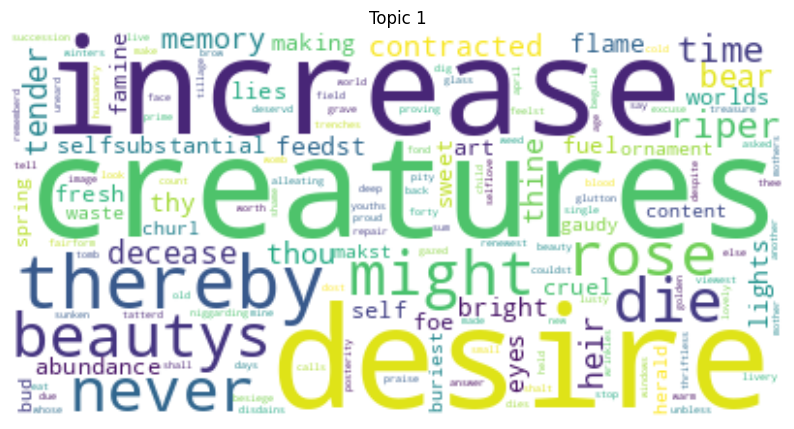

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


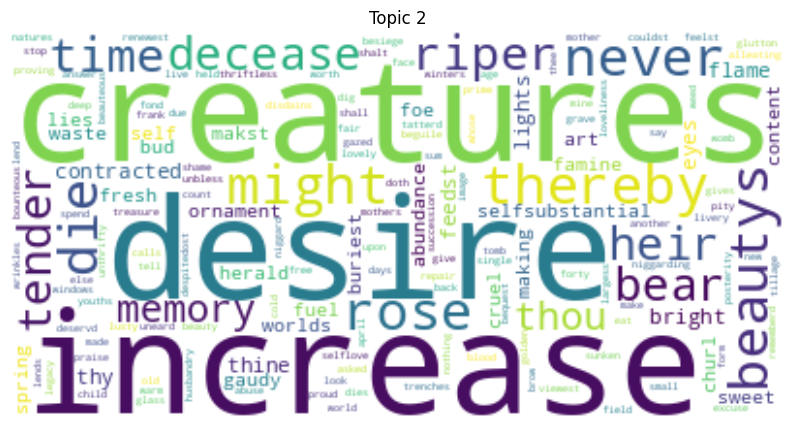

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


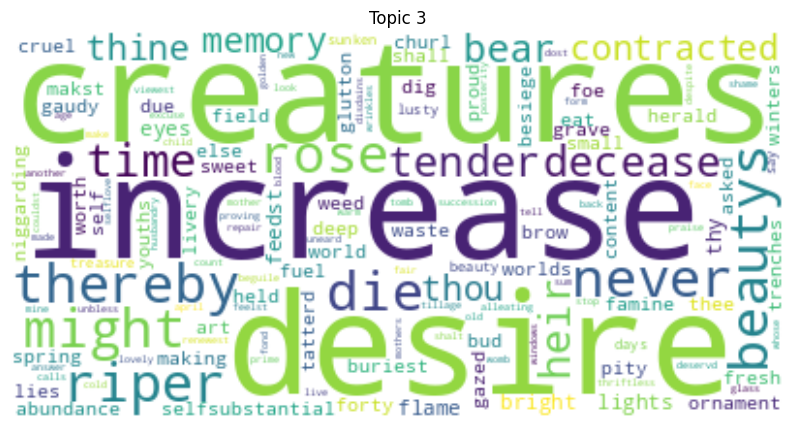

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


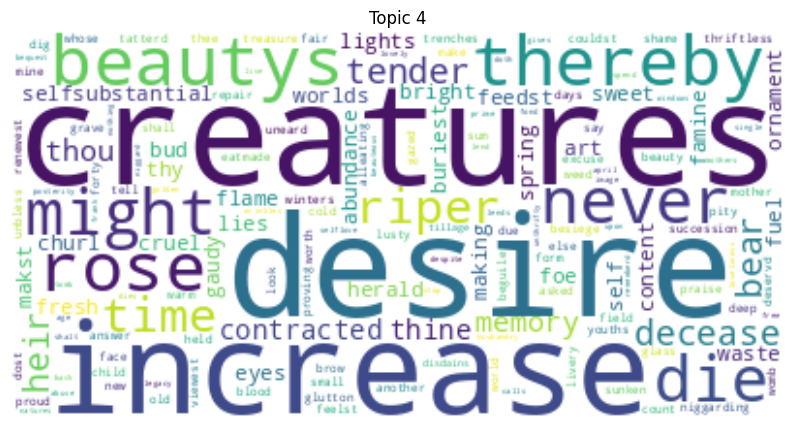

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


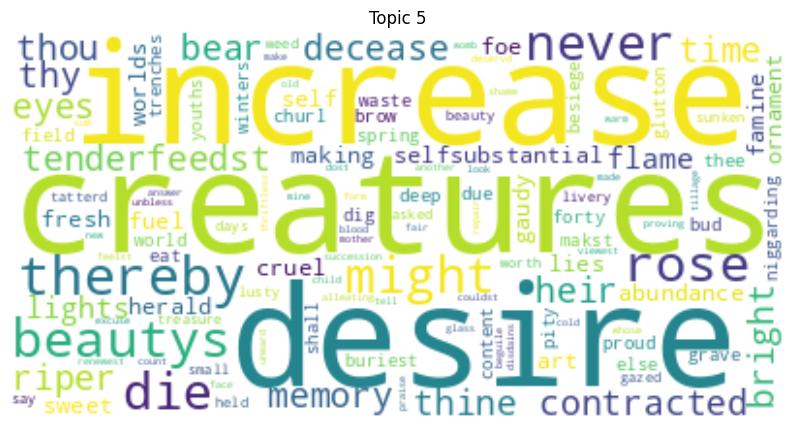

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


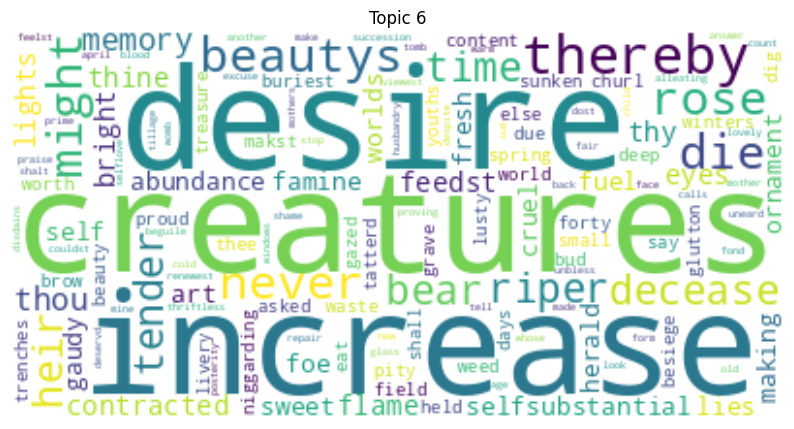

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def display_wordclouds(B, vocab):
    reversed_vocab = {v: k for k, v in vocab.items()}  # Flip key-value pairs in vocab
    for k in range(B.shape[0]):
        # Subtract 1 from the index to account for 1-indexing in B
        word_freq = {reversed_vocab[w+1]: B[k, w] for w in range(B.shape[1]) if w+1 in reversed_vocab}
        wc = WordCloud(background_color='white').generate_from_frequencies(word_freq)

        plt.figure(figsize=(10, 7))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Topic {k + 1}')
        plt.show()

display_wordclouds(B, vocab)


In [36]:
import pyLDAvis
# Update topic_term_dists
topic_term_dists /= topic_term_dists.sum(axis=1)[:, None]

# Create a reversed vocabulary for visualization
reversed_vocab = {v: k for k, v in vocab.items()}

# Correct the vocab list in the data dictionary for pyLDAvis
data = {
    'topic_term_dists': topic_term_dists,
    'doc_topic_dists': A,
    'doc_lengths': [len(text) for text in id_texts],
    'vocab': list(reversed_vocab.values()),  # list of words, not IDs
    'term_frequency': [freq[word_id] for word_id in vocab.values()]
}

# Use pyLDAvis to visualize
vis_data = pyLDAvis.prepare(**data)
pyLDAvis.display(vis_data)




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
